# Transformer
参考文章：\
[1] https://blog.csdn.net/xiaoh_7/article/details/140019530 \
[2] https://zhuanlan.zhihu.com/p/657456977

### 1 位置编码

In [ ]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
import time

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        # 根据 pos 和 i 创建一个常量 PE 矩阵
        pe=torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / 10000**((2*i)/d_model))
                pe[pos, i+1] = math.cos(pos / 10000**((2*(i+1))/d_model))
        # 增加一个批次维度，使其形状为 (1, max_seq_len, d_model)
        pe=pe.unsqueeze(0)
        # 将 pe 注册为一个缓冲区，这样它会在模型保存和加载时被保存，但不会被优化器更新
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 将输入嵌入向量 x 放大，以确保嵌入向量的值不会被位置编码淹没
        x=x*math.sqrt(self.d_model)
        # 将位置编码添加到输入嵌入向量中，其中 seq_len 是输入序列的实际长度
        x=x+self.pe[:,:seq_len]
        return x

### 2 多头注意力

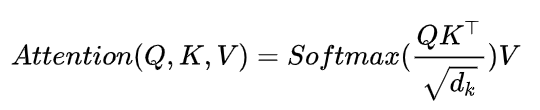

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,heads,d_model,dropout=0.1):
        super().__init__()
        self.d_model=d_model
        # 每个注意力头的维度
        self.d_k=d_model//heads
        self.h=heads
        # 将输入的查询、键和值分别映射到 d_model 维度
        self.q_linear=nn.Linear(d_model,d_model)
        self.v_linear=nn.Linear(d_model,d_model)
        self.k_linear=nn.Linear(d_model,d_model)
        self.dropout=nn.Dropout(dropout)
        self.out=nn.Linear(d_model,d_model)

    '''注意力计算'''
    def attention(self,q,k,v,d_k,mask=None,dropout=None):
        # 矩阵乘法计算查询和键的点积，然后除以 sqrt(d_k) 进行缩放，以防止梯度消失或爆炸
        # 实际上是在最后两个维度上进行矩阵乘法，k 的形状是 (batch_size, num_heads, seq_len_k, head_dim)
        scores = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
        # 如果提供了掩码（mask），则将掩码中为0的位置对应的分数设置为一个非常小的值（如 -1e9），以确保这些位置在softmax后为0
        if mask is not None:
            # 假设 scores 的形状是 (batch_size, num_heads, seq_len_q, seq_len_k)，
            # 而 mask 的形状是 (batch_size, seq_len_q, seq_len_k)。
            # 那么，mask.unsqueeze(1) 会将 mask 的形状变为 (batch_size, 1, seq_len_q, seq_len_k)
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask==0,-1e9)
        scores = F.softmax(scores,dim=-1) #归一化
        if dropout is not None:
            scores = dropout(scores)
        # 通过矩阵乘法将注意力分数与值相乘，得到加权的值
        output = torch.matmul(scores,v)
        return output
        
    def forward(self,q,k,v,mask=None):
        # 批次大小
        bs=q.size(0)
        # 对输入的查询、键和值分别进行线性变换，然后重塑为多头形式; 将这些张量进行转置，以便在注意力计算中正确对齐
        # 1 将线性变换后的张量重塑为形状 (batch_size, seq_len, num_heads, head_dim)
        # 2 将张量转置，使其形状为 (batch_size, num_heads, seq_len, head_dim)
        k=self.k_linear(k).view(bs,-1,self.h,self.d_k).transpose(1,2)
        q=self.q_linear(q).view(bs,-1,self.h,self.d_k).transpose(1,2)
        v=self.v_linear(v).view(bs,-1,self.h,self.d_k).transpose(1,2)
        # attention 方法计算多头注意力
        scores=self.attention(q,k,v,self.d_k,mask,self.dropout)
        # 将多头注意力的输出进行转置和拼接，然后通过输出线性层进行整合
        # 1 (batch_size, num_heads, seq_len, head_dim) 转置为 (batch_size, seq_len, num_heads, head_dim)
        # 2 .contiguous() 确保张量在内存中是连续存储的
        # 3 将转置后的张量重塑为形状 (batch_size, seq_len, d_model)，即将所有注意力头的输出拼接在一起
        # d_model = num_heads * head_dim
        concat=scores.transpose(1,2).contiguous().view(bs,-1,self.d_model)
        output=self.out(concat)
        return output

### 3 前馈神经网络（FeedForward）

由两个线性层和一个激活函数组成，中间包含一个丢弃层（Dropout）以防止过拟合

In [ ]:
'''增强模型的表达能力'''
class FeedForward(nn.Module):
    # d_ff 中间层的维度
    def __init__(self,d_model,d_ff=2048,dropout=0.1):
        super().__init__()
        self.linear_1=nn.Linear(d_model,d_ff)
        self.dropout=nn.Dropout(dropout)
        self.linear_2=nn.Linear(d_ff,d_model)

    def forward(self,x):
        x.self.dropout(F.relu(self.linear_1(x)))
        x=self.linear_2(x)
        return x

### 4 残差连接与层归一化（NormLayer）

这两个模块在Transformer模型中通常一起使用，FeedForward 模块用于增加模型的非线性能力，而 NormLayer 模块用于稳定训练过程和加速收敛。

In [ ]:
class NormLayer(nn.Module):
    def __init__(self,d_model,eps=1e-6):
        super().__init__()
        self.size=d_model
        # 层归一化具有两个可以学习的参数
        self.alpha=nn.Parameter(torch.ones(self.size))
        self.bias=nn.Parameter(torch.zeros(self.size))
        # 一个很小的数，用于防止除零错误
        self.eps=eps
    
    def forward(self,x):
        norm=self.alpha*(x-x.mean(dim=-1,keepdim=True)) / (x.std(dim=-1,keepdim=True)+self.eps)+self.bias
        return norm

### 5 Encoder

将输入序列（例如一段文本）转换成一系列高维特征向量，这些特征向量可以被解码器用来生成输出序列

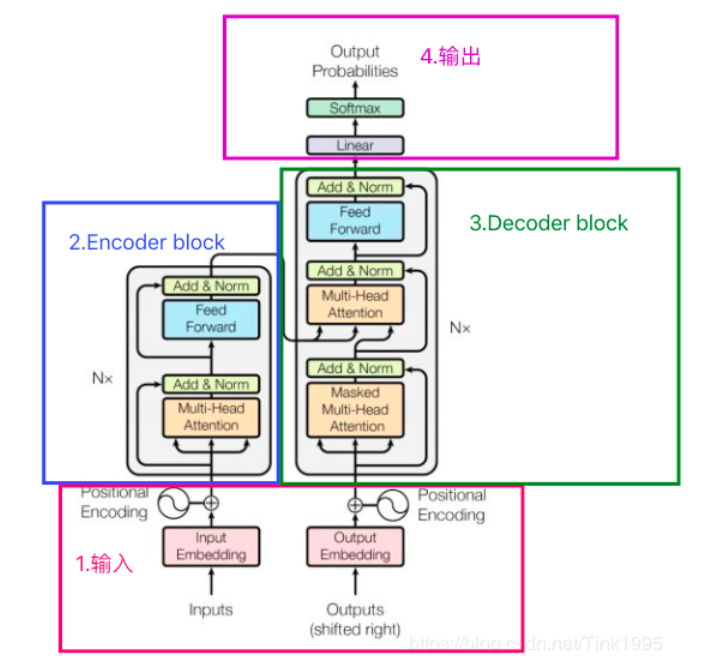

In [ ]:
'''编码器的基本组成单元'''
class EncoderLayer(nn.Module):
    def __init__(self,d_model,heads,dropout=0.1):
        super().__init__()
        # 归一化层: 在多头注意力机制和前馈神经网络之前，对输入进行层归一化
        self.norm_1=NormLayer(d_model)
        self.norm_2=NormLayer(d_model)
        # 多头注意力机制
        self.attn=MultiHeadAttention(heads,d_model,dropout=dropout)
        # 前馈神经网络
        self.ff=FeedForward(d_model,dropout=dropout)
        # 丢弃层: 在多头注意力机制和前馈神经网络的输出上应用丢弃操作，以防止过拟合
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)

    def forward(self,x,mask):
        x2=self.norm_1(x)
        # 将 dropout 后的输出与原始输入 x 相加，形成残差连接。
        # 这样做可以缓解梯度消失问题，并使得模型更容易学习
        x=x+self.dropout_1(self.attn(x2,x2,x2,mask))
        x2=self.norm_2(x)
        # 将 dropout 后的输出与经过多头注意力机制处理后的 x 相加，形成残差连接
        x=x+self.dropout_2(self.ff(x2))
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self,vocab_size,d_model,N,heads,dropout):
        super().__init__()
        self.N=N
        # 嵌入层: 将输入的词汇索引序列 (src) 转换为对应的词嵌入向量 (d_model)
        self.embed=nn.Embedding(vocab_size,d_model)
        # 位置编码器
        self.pe=PositionalEncoding(d_model)
        # 编码器层: 由 N 个 EncoderLayer 组成的列表 (每个 EncoderLayer 包含一个多头注意力机制和一个前馈神经网络，以及相应的归一化层和丢弃层)
        self.layers=nn.ModuleList([EncoderLayer(d_model,heads,dropout) for _ in range(N)])
        # 归一化层: 在所有编码器层之后，对输出进行层归一化，以稳定训练过程
        self.norm=NormLayer(d_model)

    def forward(self,src,mask):
        x=self.embed(src)
        x=self.pe(x)
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

### 6 Decoder

生成输出序列

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,d_model,heads,dropout=0.1):
        super().__init__()
        # 归一化层: 在多头注意力机制和前馈神经网络之前，对输入进行层归一化
        self.norm_1=NormLayer(d_model)
        self.norm_2=NormLayer(d_model)
        self.norm_3=NormLayer(d_model)
        # 丢弃层: 在多头注意力机制和前馈神经网络的输出上应用丢弃操作，以防止过拟合
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)
        self.dropout_3=nn.Dropout(dropout)
        # 多头注意力机制
        # 自注意力机制: 计算输入序列的自注意力表示
        self.attn_1=MultiHeadAttention(heads,d_model,dropout)
        # 编码器-解码器注意力机制: 允许解码器在生成每个位置的输出时，考虑到编码器的输出（即源语言的上下文信息）
        self.attn_2=MultiHeadAttention(heads,d_model,dropout)
        # 前馈神经网络: 一个简单的两层全连接神经网络，用于对每个位置的输入进行非线性变换
        self.ff=FeedForward(d_model,dropout)

    def forward(self,x,e_outputs,src_mask,trg_mask):
        x2=self.norm_1(x)
        x=x+self.dropout_1(self.attn_1(x2,x2,x2,trg_mask))
        x2=self.norm_2(x)
        x=x+self.dropout_2(self.attn_2(x2,e_outputs,e_outputs,src_mask))
        x2=self.norm_3(x)
        x=x+self.dropout_3(self.ff(x2))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self,vocab_size,d_model,N,heads,dropout):
        super().__init__()
        self.N=N
        # 嵌入层: 将输入的目标语言词汇索引序列（trg）转换为对应的词嵌入向量 (d_model)
        self.embed=nn.Embedding(vocab_size,d_model)
        # 位置编码器
        self.pe=PositionalEncoding(d_model)
        # 解码器层: 由 N 个 DecoderLayer 组成的列表 (每个 DecoderLayer 包含两个多头注意力机制和一个前馈神经网络，以及相应的归一化层和丢弃层)
        self.layers=nn.ModuleList([DecoderLayer(d_model,heads,dropout) for _ in range(N)])
        # 归一化层: 在所有解码器层之后，对输出进行层归一化
        self.norm=NormLayer(d_model)

    def forward(self,trg,e_outputs,src_mask,trg_mask):
        x=self.embed(trg)
        x=self.pe(x)
        for layer in self.layers:
            x=layer(x,e_outputs,src_mask,trg_mask)
        return self.norm(x)

### 7 Transformer整体框架

In [ ]:
class Transformer(nn.Module):
    def __init__(self,src_vocab,trg_vocab,d_model,N,heads,dropout):
        super().__init__()
        self.encoder=Encoder(src_vocab,d_model,N,heads,dropout)
        self.decoder=Decoder(trg_vocab,d_model,N,heads,dropout)
        self.out=nn.Linear(d_model,trg_vocab)

    def forward(self,src,trg,src_mask,trg_mask):
        e_outputs=self.encoder(src,src_mask)
        d_output=self.decoder(trg,e_outputs,src_mask,trg_mask)
        output=self.out(d_output)
        return output

### 8 模拟训练过程

In [ ]:
d_model=512
heads=8
N=6
src_vocab=len(EN_TEXT.vocab)
trg_vocab=len(FR_TEXT.vocab)
model=Transformer(src_vocab,trg_vocab,d_model,N,heads)

'''初始化模型参数'''
for p in model.parameters():
    # 如果参数的维度大于1，则使用 Xavier 均匀分布初始化参数
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

'''
创建优化器
1) Adam 优化器: 用于更新模型的参数
2) model.parameters(): 指定需要优化的参数为模型的所有参数
3) lr: 学习率
4) betas: Adam 优化器的 beta1 和 beta2 参数
5) eps: 一个很小的数，用于防止除零错误
'''
optim=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9,0.98),eps=1e-9)

'''模型训练'''
def train_model(epochs,print_every=100):
    model.train()
    start=time.time()
    temp=start
    total_loss=0
    for epoch in epochs:
        